In [305]:
%matplotlib inline

In [347]:
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['font.size'] = 24

# Virtual FCS, using MD Simulation Data

This goal of this notebook is to generate a simulated FCS measurement using data from a GROMACS simulation.

The setup of the virtual system is a membrane with a circularly symmetric incident beam.

Data is read in from an .xtc or .trr file, using a .gro file to define the system topology. Data frames from the input file are iterated through, and for each frame, a detected intensity from each lipid is calculated. The intensity trace and autocorrelation functions for each lipid, and for the total at each frame, are plotted.

## TODOs


#### ☒ Why don't autocorrelation curves look right? Flatness in middle is unexpected
- Done. See below
 
#### ☒ Generate and plot autocorrelation curve prediction. I'm still not understanding something about autocorrelation curves - I don't see where the sigmoid shape comes from.
 - Done. Curves need to be plotted on a semilog scale in order to see the expected sigmoid shape.
 
#### ☒ Try autocorrelating the data myself instead of using acorr. Maybe something weird is happening with the way matplotlib does autocorrelation that isn't desirable.
 - Done. The manually autocorrelated data is identical to calling plt.acorr with normed=True
 
#### ☒ Parallelize data analysis
 - Tried it. The analysis is quite computationally cheap compared to the extra overhead from spawning new threads -- not worth the time saved by running the analysis in parallel.
 
#### ☒ Handle breaking data up into bins better -- currently ignores the remainder of lipids that don't fall into a bin. (I.e. 11 lipids, bin size 3, the remaining 2 that don't evenly fall into bins are discarded.)
 - Done. The leftover lipids are put into their own bin, which may be smaller than the BIN_SIZE.
 
#### ☒ How do PBC vs unwrapped affect prediction of diffusion constant?
 - Done. Don't appear to significant affect results.
 
#### ☐ Curve fit method seems to work better for small spot sizes, but 0.5-crossing method seems better for larger spots? Why?

#### ☐ Come up with a way to score the different tests in the Excel spreadsheet. Factor in how close the average is, and how big the error is.
     
[Checkbox symbols]:<> (☒ ☐)

It's recommended to 'unwrap' simulation data to remove potential artifacts from periodic boundary conditions in the simulation.

### Method 1 (Better for big systems)
The *best* way of doing this requires a trajectory file (i.e. `.xtc`, `.trr`), a `.gro`, and a `.tpr`. By doing this, the input data filesizes can be significantly reduced off the bat by selecting only the lipid groups to keep in the new trajectory file. This can be accomplished by running the following.

When prompted to select a group, select only the group of lipids.

`$>gmx trjconv -f <trajectory file> -s <.gro file> -o <output trajectory file> -pbc nojump`

`$>gmx trjconv -f <.gro file> -s <.tpr file> -o <output .gro file> -pbc nojump`

### Method 2
This can also be done in one step, with only a trajectory file and a `.gro` file by selecting the group of ALL atoms when prompted.

`$>gmx trjconv -f <trajectory file> -s <.gro file> -o <output trajectory file> -pbc nojump`

## Notes on input data

In [307]:
trajectory_file = "40nm/run_nojump.xtc"
trr_file = "40nm/run.trr"
topology_file = "40nm/system_nojump.gro"

In [308]:
import mdtraj as md
import numpy as np
from scipy.optimize import curve_fit, fsolve, root
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

import multiprocessing
from multiprocessing.pool import ThreadPool

from threading import Lock # For print statements

import trajectory

plt.rcParams['figure.figsize'] = (20, 12)

## Simulation constants

In [309]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [310]:
def generate_spots(x):
    return x

interact(generate_spots, x=False);

False

#### Detection area parameters

`spot_radius` is used to determine whether a particle is within the detection area. Currently, this is unused, as cutoff is determined by the sigma of the beam Gaussian.

In [311]:
# Radius of detection area (in nanometers)
spot_radius = 10 # Currently unused

# Coordinates of detection area center (in nanometers)
spotX = 0.0
spotY = 0.0
spotZ = 10.0 # This isn't used, since we're looking at 2D membranes

#### Gaussian parameters

Note that what's being set here is the std. deviation `w_xy` of the Gaussian - spot size is probably more accurately represented by the FWHM, or `w_xy * 1.699`

In [312]:
#   Radial and axial std. dev.s of the Gaussian beam profile
FWHM = .4
w_xy = FWHM * np.sqrt(2) / (2 * np.sqrt(np.log(2)))

w_z = 2 # Unused
k = w_z/w_xy # Unused, just considering a 2-D membrane

In [313]:
w_xy

0.3397287201152077

#### Various simulation parameters

`STEP` is the stride used when iterating through data frames. Data frames are taken every timestep.

`INTENSITY` is a scaling constant used to determine the maximum intensity of fluorescence.

`SAMPLING_RATIO` defines the percentage of particles to be 'tagged'. Untagged particles are discarded at the beginning of the simulation.

`CUTOFF` defines a cutoff for the beam profile. This may be useful to avoid artifacts from periodic boundary conditions.

In [314]:
# Step size for iterating through data frames
STEP = 1

# Scaling constant for the intensity of a fluorescing particle
INTENSITY = 1

# Percentage of tagged particles
SAMPLING_RATIO = 0.4

# How many sigmas out from the beam center to truncate the beam's Gaussian profile at
CUTOFF = 2.5

# How many lipids to bin into a single trajectory
BIN_SIZE = 1

# How many random spots to use
N_SPOTS = 8

# Radius within which to randomly place spots
SPOT_RANGE = 0.75

# Whether or not to filter trajectories based on start/end position
FILTERING = False

#### Diffusion parameters

`D` is the diffusion constant for POPC, ~~using data from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1303347/~~ using values from Andrew's STRD paper$^{[2]}$, in units of nm^2/ns.

`tauD` is the expected diffusion time, or the time of the half-max for the autocorrelation curve.

In [315]:
#D = .01 From NIH paper
D = .0245
D = 15
tauD = w_xy**2 / (4*D) 
print("Expected diffusion time is %.2f nanoseconds" % tauD)

Expected diffusion time is 0.00 nanoseconds


## Expected diffusion times for various beam waists

In [316]:
beam_waists = np.arange(10,100,5) # In nanometers
print("beam FWHM (nm)".ljust(16) + "|" + "tau_D (ns)".rjust(15))
print("-"*27)
for v in beam_waists:
    print(str(v).ljust(16) + "|" + str(v ** 2 / (4*D)).rjust(15) )

beam FWHM (nm)  |     tau_D (ns)
---------------------------
10              |1.6666666666666667
15              |           3.75
20              |6.666666666666667
25              |10.416666666666666
30              |           15.0
35              |20.416666666666668
40              |26.666666666666668
45              |          33.75
50              |41.666666666666664
55              |50.416666666666664
60              |           60.0
65              |70.41666666666667
70              |81.66666666666667
75              |          93.75
80              |106.66666666666667
85              |120.41666666666667
90              |          135.0
95              |150.41666666666666


## Useful functions

### `check_in_detection_volume`
Function to check if a given lipid is within the detection volume.

Right now, we're interested in contributions from all lipids regardless of position, so the `return True` short circuits it. 

Furthermore, this is somewhat deprecated by implementing the Gaussian `CUTOFF`.

In [317]:
def check_in_detection_volume(t, frame_index, residue):

    # For now, pay attention to all atoms, regardless of whether or not they're
    #   in the detection volume. 
    # Keep this function as a placeholder, in case this changes.
    return True

    x, y, z = t.xyz[frame_index, residue._atoms[0].index]

    # Get magnitude of distance to the spot center
    distance = (x - spotX)**2 + (y - spotY)**2

    # Check if the distance is within the spot radius
    in_detection_area = distance <= spot_radius**2

    return in_detection_area

### `generate_detection`
Defines what happens when a detection is generated from a lipid. Right now, `INTENSITY` is weighted by a 2-D Gaussian determined by the cell's position:

$I = I_0 \exp{ \left( - \frac{(x-x_0)^2 + (y-y_0)^2 }{2 \sigma^2} \right) }$

#### Inputs
- `t`: mdtraj.Trajectory object
- `frame_index`: index of frame to analyze in trajectory  
- `atom`: mdtraj.Atom object to be used for detection

#### Returns
- Intensity contribution from `atom`

In [318]:
def generate_detection(t, frame_index, atom, spotcenter):
    
#     print(np.shape(t.xyz))
    _x = spotcenter[0]
    _y = spotcenter[1]

    # Get coordinates of residue (more correctly, of the P atom)
    #x, y, z = t.xyz[frame_index, residue._atoms[0].index]
    try:
        x, y, z = t.xyz[frame_index, atom.index]
    except IndexError:
        raise IndexError("Indexing error. Attempting to use frame index %d and atom index %d. Shape is %s" % (frame_index, atom.index, t.xyz.shape))
    
    # Get magnitude of distance to the spot center
    distance = (x - _x)**2 + (y - _y)**2
    
    # Truncate at 2 sigma
    if distance > CUTOFF**2 * w_xy**2:
        return 0.0

    # Calculate contribution to intensity from an atom, based on the Gaussian
    #   profile of the incident beam and the particle's position.
    intensity = \
        INTENSITY * np.exp(
        -( distance * 2 ) # + ((z - spotZ)/k)**2)
        / (w_xy**2) )

    return intensity

### `analyze_frame`

Analyzes the positions of atoms in a given frame, and updates the `detections` list with each atom's position.

#### Inputs
- `t`: mdtraj.Trajectory object
- `frame_index`: index of frame to analyze in trajectory  
- `detections`: shared list of all detections

In [319]:
def analyze_frame(t, frame_index, detections, spot_number=0, spotcenter=(spotX, spotY)): 
    
    print("\rProcessing frame %d out of %d     " % (frame_index/STEP, len(t)/STEP), end="\r")

    # Iterate through each atom remaining in the topology
    for atom in t.topology.atoms:

        # Do analysis if atom is in detection volume
        if not check_in_detection_volume(t, frame_index, atom):
            print("Not in detection volume, skipping.")
            continue

        detected = generate_detection(t, frame_index, atom, spotcenter)
        
        detections[spot_number][atom.index][int(frame_index/STEP)] += detected

In [320]:
def analyze_frame_mp(t, frame_index, detections, spotcenter=(spotX, spotY)): 
    
#     print("\rProcessing frame %d out of %d     " % (frame_index/STEP, len(t)/STEP), end="\r")

    # Iterate through each atom remaining in the topology
    for atom in t.topology.atoms:

        # Do analysis if atom is in detection volume
        if not check_in_detection_volume(t, frame_index, atom):
#             print("Not in detection volume, skipping.")
            continue

        detected = generate_detection(t, frame_index, atom, spotcenter)
        
#         print(atom.index)
        detections[atom.index][int(frame_index/STEP)] += detected

### `autocorr_model`

Models the expected autocorrelation curve at a given time, for a given diffusion constant.

#### Inputs
- `t`: Time to calculate autocorrelation at
- `D`: Diffusion constant

#### Returns
- Value of autocorrelation curve at time `t`

In [321]:
def autocorr_model(t, D):
#     tauD = FWHM**2 / (4*D)

    tauD = w_xy**2 / (4*D)
    
    _acorr = 1./(1. + t / tauD)
    
#     if np.nan in _acorr:
#         print(_acorr)
#         _acorr = -1
#         print("NaN!")
    
    return _acorr

### `autocorrelate`
Computes the autocorrelation curve for a set of data.

$G(\Delta t) = \frac{ 
\sum_{i=0}^{M-\Delta t} 
(I(i) - \langle I \rangle)
(I(i+\Delta t) - \langle I \rangle )}
{\sigma_I^2 (M-\Delta t)}$

#### Inputs
- `_data`: 1-D array of data
- `normed`: Boolean, determines whether to normalize data to unity. Default - `True`

#### Returns
- `autocorrelated`: Autocorrelation for input data

In [322]:


def autocorrelate(_raw, normed=True, reduction=1, step=1):
    
    _data = _raw
    if normed:
        _data = _raw/np.linalg.norm(_raw)
        
    autocorrelated = np.correlate(_data, _data, mode='full')
    autocorrelated = autocorrelated[(autocorrelated.size-1)//2 :]

#     print("Length of data is %d" % len(_data))
#     max_lag = len(_data)//reduction
#     print("Max lag is %d" % max_lag)
# #     time_lags = np.arange(max_lag)
#     G = np.zeros(max_lag)
#     I = np.mean(_data)
#     stdI = np.std(_data)
#     M = len(_data)
#     tau = 1
#     for dt in range(max_lag):
        
#         m = dt
        
        
#         G[dt] = np.sum( [ \
#                 (_data[tau*i] - I) * \
#                 (_data[tau*i + m*tau] - I) \
#             for i in range(0,M-m,step)])
        
#         G[dt] = G[dt] / (stdI**2 * (M-m))
        
#         if dt % 100 == 0:
#             print("Calculated %d" % dt, end="\r")
#     autocorrelated = G
        
    
    
    
    
    return autocorrelated

### `gauss2d`

Computes the value of a 2-D Gaussian.

#### Inputs
- `xy`: list of (x,y) tuples
- `spot`: (x,y) tuple of coordinates of center of detection area
- `sigma`: Standard deviation of Gaussian
- `cutoff`: Number of standard deviations after which to truncate Gaussian and return 0. Default - `CUTOFF`

#### Returns
- `z`: A flat list of the value of the Gaussian at each input point.

In [323]:
 def gauss2d(xy, spot, sigma, cutoff=CUTOFF):
    x, y = xy
    x0, y0 = spot
    distance = (x - x0)**2 + (y - y0)**2
    
    # Set values outside the cutoff to 0
    s2 = (cutoff * sigma)**2 # Define this so I don't have to keep recomputing it in the list comprehension
    distance = np.array([d if d < s2 else 1e10 for d in distance])
    
    z = np.exp(-(distance)*2/( sigma**2))
    
    # Returns an array of the Z values
    return z

### `get_crossings`
Gets the 0-crossing of a set of normalized data. This will only find one 0-crossing and can be quite sensitive to the initial guess provided to the solver.

#### Inputs
- `x`: List of x values
- `data`: Normalized set of data
- `guess`: Initial guess to solver (not used any more, went for a simpler approach)

#### Returns
- `crossing`: x coordinate of 0 crossing

In [324]:
def get_crossing(x, data, guess=-1):
    
    if np.isnan(data).all():
        raise ValueError("All NaN, no intensity contributions")
        return False
    
    
    crossing = 0
    for t in range(len(data)):
        if data[t] > 0.5:
            crossing+=1 # Go to the next point if you haven't crossed yet
            
        else:
            # Do a little linear interpolation between the crossed point and the previous
            if t == 0:
                start = 1
            else:
                start = data[t-1]
                
            m = start-data[t]
            crossing = (start - 0.5) / m
            
            return t-1 + crossing
        
    return False





#     interpolated = interp1d(x, data - .5, fill_value='extrapolate')
# #     interpolated = np.interp(x, data - .5, left=1, right=0)
    
    
#     try:
#         crossing = fsolve(interpolated, 0)# tauD)
#     except ValueError:
#         print("**** BAD GUESS *****")
#         print("Skipping this spot...")
#         raise ValueError("Bad guess.")
#         return False
        
    return crossing

### `analyze_spot_mp`

Function to analyze detections from a given spot. Suitable for multiprocessed applications.

#### Inputs
- `t`: Trajectory (or FakeTrajectory) object
- `spot`: (x,y) tuple of center of spot to use
- `detections`: Queue object to store detections in
- `spot_num`: Index of spot.

#### Returns
- None. However, will add a tuple of (spot_num, \_detections) to the queue, where detections is an np array of shape (n_residues, number of timesteps) storing the detections for each residue.

In [325]:
def analyze_spot(t, spot, detections, spot_num):
    for frame_index in range(0, len(t), STEP):
        analyze_frame(t, frame_index, detections, spot_num, spot)

def analyze_spot_mp(t, spot, detections, spot_num):
    _detections = np.full(shape=(t.topology.n_residues, int(np.ceil(len(t)/STEP))), fill_value=0.0) 
    for frame_index in range(0, len(t), STEP):
        analyze_frame_mp(t, frame_index, _detections, spot)
    detections.put((spot_num, _detections))
    
    print("{} particles contribute to spot {} detections".format(len(_detections), spot_num))

### `calibrate`
Function to calibrate results of diffusion constant calculation.

#### Inputs
- `dtype`: CROSSING or CURVE_FIT or ALL_AVG, constants which map to 0 or 1. Determine the calibration to use.
- `D`: Diffusion constant or list of diffusion constants to calibrate

#### Returns
- `D`: Corrected diffusion constant, or list of diffusion constants.

In [326]:
CROSSING = 0
CURVE_FIT = 1
ALL_AVG = 2

def calibrate(dtype, D):
    D = np.array(D)
    return[
        D - .0151*FWHM - 4.3649,
        D - .0671*FWHM + .0454,
        D - .1023*FWHM - 4.6588
    ][dtype]

## Load trajectory data

Import FCS data from .xtc file. Also specify a .gro file for the system topology.

**NB:** A .trr file can be used for better resolution, since an .xtc typically uses some compression. However, a .trr is also much larger.

In [327]:
%%time
# t = md.load(trajectory_file, top=topology_file)
#t = md.load_trr(trr_file, top=topology_file)

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 13.8 µs


Calculate timestep for data analysis, given the simulation data timestep and current stride.

In [328]:
# print("Timestep for data analysis is %.2f picoseconds (%.2f nanoseconds)" % (t.timestep * STEP, t.timestep * STEP / 1000))

In [329]:
# print("Starting with %d atoms" % t.topology.n_atoms)

# phosphorous_atoms = [a.index for a in t.topology.atoms if a.element.symbol == 'P']
# t.atom_slice(phosphorous_atoms, inplace=True)

# print("Reduced to %d phosphorous atoms" % t.topology.n_atoms)

# # Reduce to the sampling ratio * number of phosphorous atoms
# num_sampled = int(t.topology.n_atoms * SAMPLING_RATIO)

# # Randomly select the sampled atoms
# sampled = np.random.choice([a.index for a in t.topology.atoms], num_sampled, replace=False)
# t.atom_slice(sampled, inplace=True)

# print("Reduced to %d \"tagged\" phosphorous atoms" % t.topology.n_atoms)

## Reduce atom selection to only phosphorous atoms

This is a bit of a simplification, but significantly reduces the amount of atoms to iterate over if we're only considering the phosphorous at the center of the phosphate group. Error from this would be on the order of the bond lengths, so roughly 1.5 angstrom.

## Import data from Pickle file

In [330]:
import pickle, trajectory
# t = pickle.load(open('../Ld_combined.pkl', 'rb'))
t = pickle.load(open('../Lo_combined.pkl', 'rb'))
# t = pickle.load(open('../D152.pkl', 'rb'))
# print("Shape is %s, reducing by %d%%." % (np.shape(t.xyz), 100-SAMPLING_RATIO*100))
t.reduce(SAMPLING_RATIO)
print(np.shape(t.xyz))

trajectories = []
print(int(t.topology.n_residues / BIN_SIZE))

# BIN_SIZE is used a little differently with this technique -- applies to binning trajectories in the experiment itself, rather than binning experimental data during analysis.
# import copy
for traj in range(int(t.topology.n_residues / BIN_SIZE)):
    _t = trajectory.FakeTrajectory()
    _t.initialize(t.xyz[:,BIN_SIZE*traj:BIN_SIZE*(traj+1)], BIN_SIZE)
#     _t = copy.deepcopy(t)
#     _t.xyz = t.xyz[:,BIN_SIZE*traj:BIN_SIZE*(traj+1)]
#     _t.topology.n_residues = BIN_SIZE
#     _t.topology.atoms = t.topology.atoms[BIN_SIZE*traj:BIN_SIZE*(traj+1)]
#     _t.reindex()
    trajectories.append(_t)
# N_SPOTS = len(trajectories)
# print(N_SPOTS)

XYZ: 21450, N_ATOMS: 10
XYZ: 21450, N_ATOMS: 4
(21450, 4, 3)
4


Create a list of lists to store detected intensity at each timestep for each lipid.

In [331]:
# %%time
detections = np.full(shape=(N_SPOTS, t.topology.n_residues, int(np.ceil(len(t)/STEP))), fill_value=0.0)
# detections = np.full(shape=(len(trajectories), BIN_SIZE, int(np.ceil(len(t)/STEP))), fill_value=0.0)

# Data Analysis

Iterate through each frame of data in the trajectory file, and generate a detected intensity from each lipid (represented by its head group P atom).

In [332]:
# _oldspots = spot_centers
# lo = _oldspots
# ld = spot_centers

# spot_centers = lo
# spot_centers = np.array([ [np.random.uniform(-0.3,0.4), np.random.uniform(-0.2,0.2)] for x in range(N_SPOTS)])
# spot_centers = np.array([ [np.random.uniform(-SPOT_RANGE,SPOT_RANGE), np.random.uniform(-SPOT_RANGE,SPOT_RANGE)] for x in range(N_SPOTS)])

# spot_centers = [[1.57666814, 2.27445561],
#  [1.45451181, 2.28472249],
#  [1.5820474,  2.315859  ],
#  [1.60105771, 2.23473633],
#  [1.49375276, 2.15073091],
#  [1.61871955, 2.36478765],
#  [1.57338603, 2.28992898],
#  [1.46471912, 2.37245311]]
# [[1.96604812 1.91627846]
#  [1.76389349 2.97785923]
#  [1.15984199 2.43058837]
#  [1.22271718 1.86908229]
#  [1.28333494 2.76935033]
#  [1.01740676 2.50635394]
#  [1.3402123  1.93760266]
#  [1.03711774 1.88395322]]

#RW D=15
# spot_centers = [[ -577.50358978,  -164.15006477],
#  [  -17.46804532,  1218.84142507],
#  [  983.55472215,   794.33299182],
#  [ 1318.53721119,  -842.50881855],
#  [ -728.49528786, -1464.37874692],
#  [  593.79729023,   260.1170725 ],
#  [  127.8605202,   -958.00942765],
#  [  751.50844664, -1247.25925408]]

# #Lo Combined
spot_centers = [[-0.26603705, -0.06125401],
 [ 0.15663987, -0.32246506],
 [-0.09046004,  0.09810174],
 [ 0.39177711, -0.15097893],
 [ 0.29186932,  0.26387851],
 [-0.0542699,  -0.01204657],
 [ 0.29260852,  0.36010829],
 [ 0.17887288,  0.15391496]]


# LD Combined
# spot_centers = np.array([[ 0.09421959,  0.4091756 ],
#  [ 0.13254487,  0.15201018],
#  [ 0.18950583, -0.12612968],
#  [-0.02149662, -0.23683456],
#  [-0.44049544,  0.23180748],
#  [-0.43959352,  0.13862339],
#  [-0.35754735,  0.52322731],
#  [-0.07715432,  0.47304855]])
print(spot_centers)

[[-0.26603705, -0.06125401], [0.15663987, -0.32246506], [-0.09046004, 0.09810174], [0.39177711, -0.15097893], [0.29186932, 0.26387851], [-0.0542699, -0.01204657], [0.29260852, 0.36010829], [0.17887288, 0.15391496]]


Filter out any trajectories that are already in the spot area at t=0 or t=t_max

In [333]:
# Iterate over each single-particle trajectory
start_filtered = 0
end_filtered = 0
if FILTERING:
    spotX = 0
    spotY = 0
    for traj in trajectories:
        
        start = traj.xyz[0,0,:2]
        end = traj.xyz[-1,0,:2]


        start_distance = (start[0] - spotX)**2 + (start[1] - spotY)**2
        end_distance = (end[0] - spotX)**2 + (end[1] - spotY)**2

#         if start_distance < (CUTOFF * w_xy)**2:
#             traj.xyz[:,0,:2] = [3000,3000]
#             start_filtered += 1
        if end_distance > (CUTOFF * w_xy)**2:
            traj.xyz[:,0,:2] = [3000,3000]
            end_filtered += 1
            
print("%d particles filtered for start location" % start_filtered)
print("%d particles filtered for end location" % end_filtered)

0 particles filtered for start location
0 particles filtered for end location


### Legacy threaded implementation

Much slower than the process equivalent code below. Keeping it *just in case*.

This threaded code works on having each analyze_spot 

In [334]:
# spot_centers = np.random.uniform(-SPOT_RANGE, SPOT_RANGE, size=(N_SPOTS,2))

# def analyze_spot(t, spot, detections, spot_num):
#     for frame_index in range(0, len(t), STEP):
#         analyze_frame(t, frame_index, detections, spot_num, spot)

# pool = ThreadPool()

# print("Performing analysis for %d randomly assigned spots, parallelized over %d cores." % (N_SPOTS, multiprocessing.cpu_count()))

# for i in range(N_SPOTS):
#     pool.apply_async(analyze_spot, args=(t, spot_centers[i], detections, i))
    
# pool.close()
# pool.join()

# print("\n\n", end='', flush=True) # Flush stdout so the printed output doesn't spread itself into the next few output cells

### Process implementation

#### Iterate over a number of random spots

In [335]:
print("Performing analysis for %d randomly assigned spots, parallelized over %d cores." % (N_SPOTS, multiprocessing.cpu_count()))

# Set up a pool to draw workers from.
pool = multiprocessing.Pool()

# Need to use a Manager to share the Queue across multiple workers in different processes.
#   Using a Queue allows each process to access a shared object. Typically processes cannot do this
#   but threads can. However, implementing this parallelization in processes yields a ~6x speedup
#   over the threaded equivalent.
m = multiprocessing.Manager()
detections_Q = m.Queue(N_SPOTS)


# Make a list to hold AsyncResult objects. This is useful for debugging - call job.get() for an element to see
#    any exceptions that were raised. Otherwise, they'll fail silently.
jobs = [] 
for i in range(N_SPOTS):
    jobs += [pool.apply_async(analyze_spot_mp, args=(t, spot_centers[i], detections_Q, i))]
pool.close()
pool.join()


# Process the queued data, and add it to the detections list.
print("Processing queued data")

# detections = [x for x in iter(detections_Q.get, None)] # This should work, but throws a ValueError. Whatever.
for i in range(N_SPOTS):
    if detections_Q.empty():
        print("Queue prematurely empty..")
        break
    _spot, _detection = detections_Q.get()
    detections[_spot] = _detection
#     print("{} detections for spot {}".format(len(detections[_spot]), _spot))
    
print("Done")

Performing analysis for 8 randomly assigned spots, parallelized over 12 cores.
4 particles contribute to spot 2 detections
4 particles contribute to spot 4 detections
4 particles contribute to spot 1 detections
4 particles contribute to spot 5 detections
4 particles contribute to spot 3 detections
4 particles contribute to spot 7 detections
4 particles contribute to spot 0 detections
4 particles contribute to spot 6 detections
Processing queued data
Done


In [336]:
# detections[1].shape
# np.sum(detections[3], axis=0)

### Iterate over entire dataset, vs over multiple random spots

In [337]:
detections.shape

(8, 4, 21450)

### Bin lipids in data

`binned_tots[bin][timestep]` is the total intensity for a certain bin at a certain timestep

`binned_avgs[spot][bin]` is the average intensity for a bin, over the whole time

`binned_dI[spot][bin][timestep]` is the difference of the total intensity from the average at a given timestep

`binned_tot[spot][timestep]` is the average dI from all bins at a certain timestep

In [338]:
#n_bins = int(np.ceil(trajectories[0].topology.n_residues/BIN_SIZE))
n_bins = int(np.ceil(t.topology.n_residues/BIN_SIZE))

print("{} residues in this trajectory".format(trajectories[0].topology.n_residues))

# print("Attempting to bin %d residues into %d bins of size %d." % (t.topology.n_residues, n_bins, BIN_SIZE))

if not t.topology.n_residues%BIN_SIZE == 0:
    print("Number of residues is not evenly divisible by bin size. Desired size is %d, one bin will contain %d." % (BIN_SIZE, t.topology.n_residues%BIN_SIZE) )

binned_tots = np.zeros(shape=(N_SPOTS, n_bins, len(t)))
binned_avgs = np.zeros(shape=(N_SPOTS, n_bins, len(t)))
binned_dI = np.zeros(shape=(N_SPOTS, n_bins, len(t)))
binned_tot = np.zeros(shape=(N_SPOTS, len(t)))
    
    
# With the method of spots, this doesn't work as it should <- What does this mean?
num_detections = 0
for spot_num in range(N_SPOTS):
#     print("Sorting data into %d groups" % n_bins)

    binned =  [ [] for x in range(t.topology.n_residues//BIN_SIZE) ]


    # TODO: May want to use np.random.choice to randomly select the binned lipids, though the choice of lipids to sample is already random
    # For each group...
    for g in range(n_bins):

        # Pick the slice of detections that are relevant to this bin
        _detections = [x for x in detections[spot_num][g*BIN_SIZE:BIN_SIZE*(g+1)]]
        
#         print(np.count_nonzero(_detections))
        # If no detections, remove this from data
        if np.count_nonzero == 0:
            continue
#         print(len(_detections))

        # Average and total intensity at each timestep
        avg_I = np.mean(_detections)
        tot_I = np.sum(_detections, axis=0)
        
        num_detections += np.count_nonzero(_detections)
    
        print("Bin/Spot: {}/{} | Detections: {}".format(g, spot_num, np.count_nonzero(_detections)))

        # The delta is the difference between the sum of the detections at a timestep
        # and the average across all timesteps.
        delta_I = [tot_I[x] - avg_I for x in range(len(tot_I))]


#         binned_tots[spot_num][g] = tot_I
        max_intensity = max(tot_I)
    
        binned_tots[spot_num][g] = [i if max_intensity > 0.2 else 0 for i in tot_I]
        binned_avgs[spot_num][g] = avg_I
        binned_dI[spot_num][g] = delta_I

    # binned_tot = np.sum(binned_tots, axis=0) - np.mean(binned_tots)
    
    
    binned_tot[spot_num] = np.sum(binned_tots[spot_num], axis=0) # Summed intensity across bins for each spot
    
    max_intensity = max(binned_tot[spot_num])
#     binned_tot[spot_num] = np.array([x if max_intensity > 0.2 else 0 for x in binned_tot[spot_num]])
#     if max(binned_tot[spot_num]) < 0.2:
#         binned_tot[spot_num] = np.empty((len(binned_tot[spot_num])))
#         binned_tot[spot_num][:] = np.nan
print("Detected %d intensity contributions" % num_detections)

1 residues in this trajectory
Bin/Spot: 0/0 | Detections: 21450
Bin/Spot: 1/0 | Detections: 21450
Bin/Spot: 2/0 | Detections: 21450
Bin/Spot: 3/0 | Detections: 21450
Bin/Spot: 0/1 | Detections: 21450
Bin/Spot: 1/1 | Detections: 21450
Bin/Spot: 2/1 | Detections: 21450
Bin/Spot: 3/1 | Detections: 21447
Bin/Spot: 0/2 | Detections: 21450
Bin/Spot: 1/2 | Detections: 21450
Bin/Spot: 2/2 | Detections: 21450
Bin/Spot: 3/2 | Detections: 21450
Bin/Spot: 0/3 | Detections: 21450
Bin/Spot: 1/3 | Detections: 21450
Bin/Spot: 2/3 | Detections: 21450
Bin/Spot: 3/3 | Detections: 21388
Bin/Spot: 0/4 | Detections: 21450
Bin/Spot: 1/4 | Detections: 21450
Bin/Spot: 2/4 | Detections: 21183
Bin/Spot: 3/4 | Detections: 21450
Bin/Spot: 0/5 | Detections: 21450
Bin/Spot: 1/5 | Detections: 21450
Bin/Spot: 2/5 | Detections: 21450
Bin/Spot: 3/5 | Detections: 21450
Bin/Spot: 0/6 | Detections: 21450
Bin/Spot: 1/6 | Detections: 21450
Bin/Spot: 2/6 | Detections: 19237
Bin/Spot: 3/6 | Detections: 21450
Bin/Spot: 0/7 | De

Compute average numbers of particles contributing to the intensity. (I.e., that have a nonzero intensity)

In [339]:
n_nonzero = 0
n_tot = 0
n_zero = 0

# Get the number of particles that don't contribute
for i in range(N_SPOTS):
    n_zero += np.all(detections[i,:,:] == 0)
print("%d zero contributions" % n_zero)
print("%d out of %d particles contribute intensities to all spots" % (t.topology.n_residues*N_SPOTS - n_zero, t.topology.n_residues*N_SPOTS))


# # Get total number of nonzero contributions
# for spot_num in range(N_SPOTS):
#     for particle in detections[spot_num]:
#         _nonzero = [x for x in particle if not x == 0.0 ]
#         n_nonzero += len(_nonzero)
#         n_tot += len(particle)
    
# # Get total number of detections
# # n_detections = N_SPOTS * t.topology.n_residues * len(t)

# print("Average percentage of the %d sampled particles that contribute to intensity is %f%%" % (t.topology.n_residues, 100 * n_nonzero / n_tot))

0 zero contributions
32 out of 32 particles contribute intensities to all spots


## Plotting

# Intensity Traces
Plot the intensity traces for the individual lipids, and for the summed intensities.

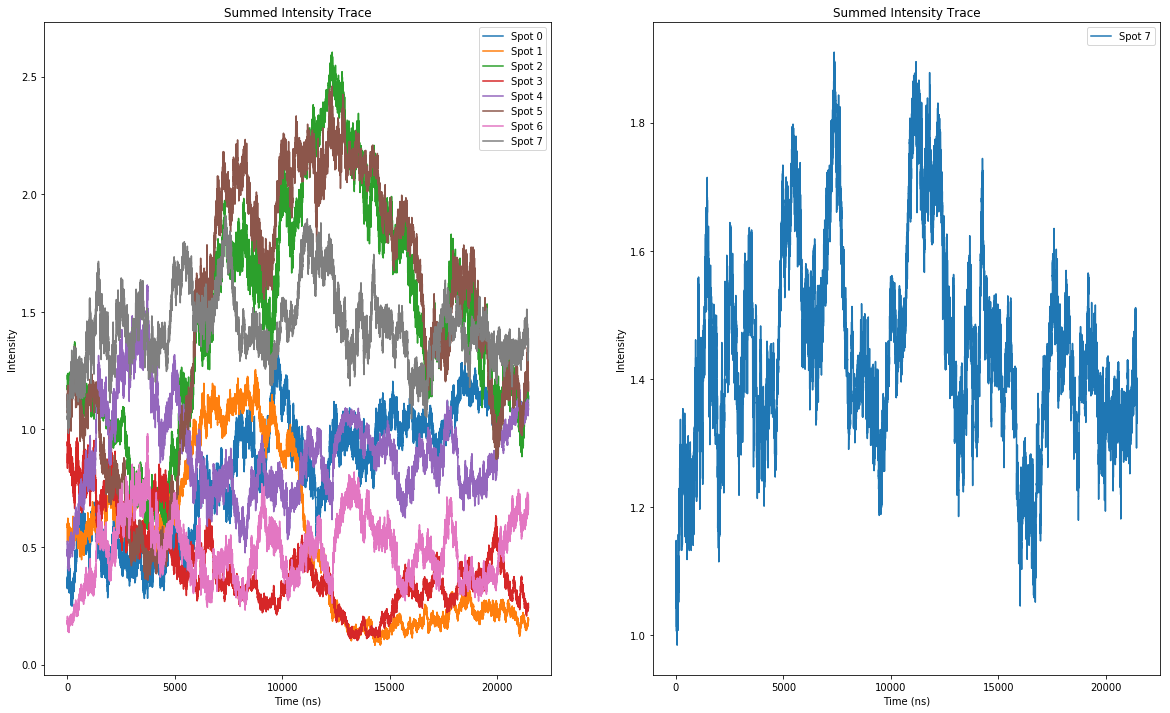

In [340]:
################## Plot intensity traces #############################
# Plot the intensities of detections associated with each lipid
# plt.subplot(221)
# # for _data in binned_dI:
# #     plt.plot(np.arange(0, len(t), 1), _data, marker='o', markersize=.5 ) 
# plt.xlabel("Time (ns)")
# plt.ylabel("Intensity")
# plt.title("Intensity Trace")

# Plot sum of intensities (i.e. what a detector would see)
plt.subplot(121)


for spot_num in range(N_SPOTS):
    plt.plot(np.arange(0, len(t), 1), binned_tot[spot_num], marker='None', label="Spot %d" % spot_num)
# plt.plot(binned_dI[6][0][17700:19600], marker='None', label="Spot %d" % spot_num)
# plt.plot(binned_tots[6][0][11500:12500], marker='None', label="Spot %d" % spot_num)
    
    
# plt.plot(np.arange(0, len(t), 1), binned_tot[0], marker='None', markersize=.5 ) 
# summed_data = np.sum(intensities, axis=0)
# #plt.plot(np.arange(0,len(summed_data), 1), summed_data, marker = 'o', markersize=.1, )
# plt.plot(np.arange(0,len(binned), 1), [x[1] for x in binned], marker = 'o', markersize=.1, )
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Summed Intensity Trace");

plt.subplot(122)
plt.plot(np.arange(0, len(t), 1), binned_tot[7], marker='None', label="Spot %d" % spot_num)
plt.legend()
plt.xlabel("Time (ns)")
plt.ylabel("Intensity")
plt.title("Summed Intensity Trace");

Text(0,0.5,'Intensity')

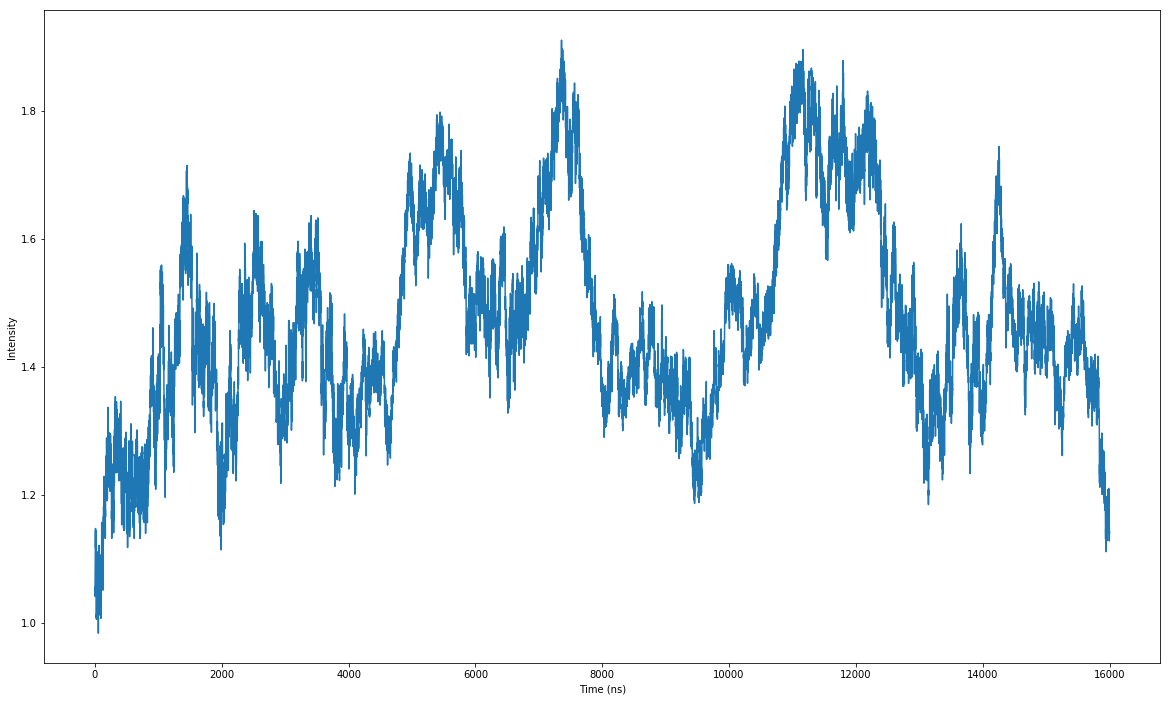

In [341]:
plt.plot(np.arange(0, 16000, 1), binned_tot[7][:16000], marker='None', label="Spot %d" % spot_num)

np.savetxt("intensity.dat", binned_tot[7])

plt.xlabel("Time (ns)")
plt.ylabel("Intensity")

###### Windowing out transits

It seems like if you don't specifically window around one transit event, the long lag time anticorrelations pop up.
So, I want to come up with a way to window out a single transit event

### Autocorrelations
Plot the autocorrelation functions for the individual lipids tracked, and for the summed intensities of all of them.

# Determine diffusion coefficient from FCS data

The following cells determine the diffusion coefficient from the FCS data using two different techniques. The binned and summed data are treated separately. First, a curve is fit to the autocorrelation curve using the diffusion constant as the parameter.

### Curve Fitting


Using the equation for diffusion in a membrane presented by Schwille$^{[1]}$, attempt to fit the FCS data to a function of the form

$G(t) = \frac{1}{N} \left(1 + \frac{t}{\tau_D} \right)^{-1}$, where

$\tau_D = \frac{w_{xy}^2}{4 D}$

Since the autocorrelation curves are normalized, $N$ is set to 1.

#### Binned

#### Summed

D was 4.260e-06 +/- 1.592e-08
D was 3.310e-06 +/- 1.319e-08
D was 5.541e-06 +/- 2.053e-08


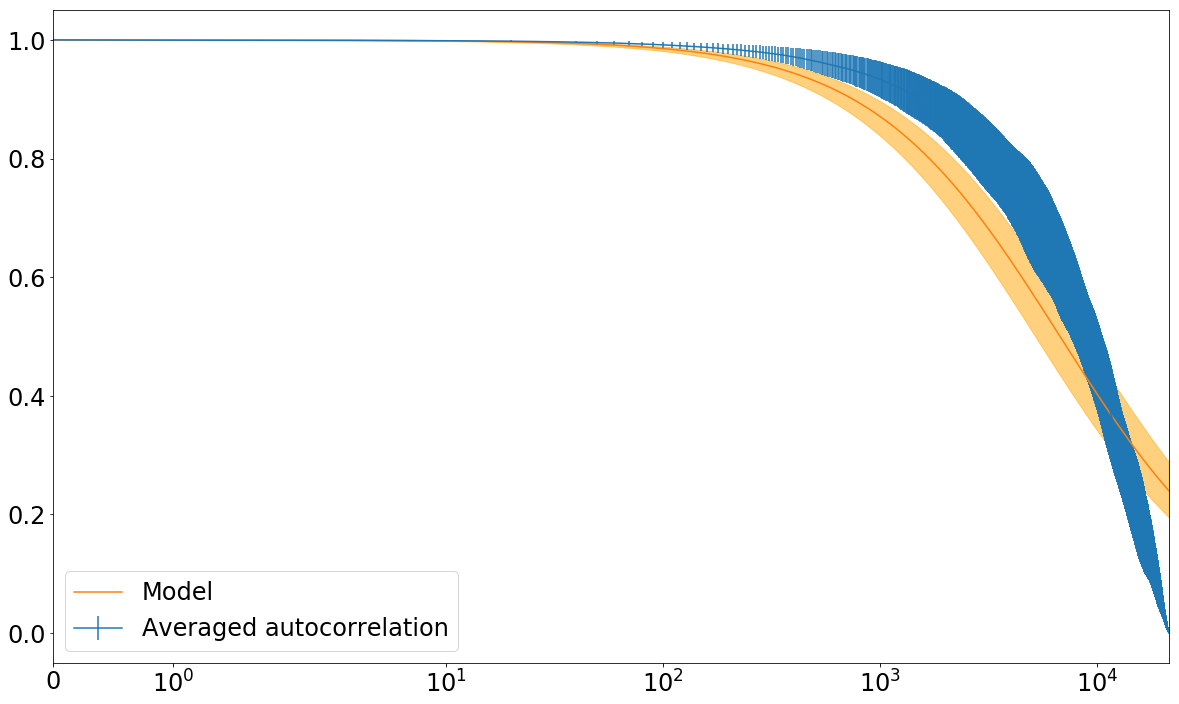

In [355]:
acorred = []

_x = np.arange(0,len(binned_tot[0]),1)

for spot_num in range(len(binned_tot)):

    autocorrelated = autocorrelate(binned_tot[spot_num])
    
    acorred.append(autocorrelated)
    
avg_acorr = np.nanmean(acorred, axis=0)
# std_acorr = [x if x > 0.0 else 1 for x in np.nanstd(acorred, axis=0)]
std_acorr = np.nanstd(acorred, axis=0)
# print(std_acorr)
# print(min(std_acorr))
# print(max(std_acorr))
# print(std_acorr)

max_fitlen = -1
# _x = _x[0:max_fitlen]
# avg_acorr = avg_acorr[0:max_fitlen]
# std_acorr = std_acorr[0:max_fitlen]


# optimal, covariance = curve_fit(autocorr_model, _x[:max_fitlen], avg_acorr[:max_fitlen], p0=1, \
#                                 bounds=(1e-7, 1e7), sigma=std_acorr[:max_fitlen], absolute_sigma=True)
optimal, covariance = curve_fit(autocorr_model, _x[100:max_fitlen], avg_acorr[100:max_fitlen], p0=1, \
                                bounds=(1e-7, 1e7))

# plt.plot(avg_acorr, label="Averaged autocorrelation")
plt.errorbar(_x, avg_acorr, yerr=std_acorr, errorevery=10, label="Averaged autocorrelation")

optimal2, covariance2 = curve_fit(autocorr_model, _x[0:max_fitlen], avg_acorr[0:max_fitlen]-std_acorr[0:max_fitlen], p0=1, \
                                bounds=(1e-7, 1e7))
optimal3, covariance3 = curve_fit(autocorr_model, _x[0:max_fitlen], avg_acorr[0:max_fitlen]+std_acorr[0:max_fitlen], p0=1, \
                                bounds=(1e-7, 1e7))

plt.plot(_x, autocorr_model(_x, optimal), label="Model")


D_mean = np.mean(optimal)
D_err = np.sqrt(np.diag(covariance))[0]

_y1 = autocorr_model(_x, np.mean(optimal2))
_y2 = autocorr_model(_x, np.mean(optimal3))

plt.fill_between(_x, _y1, _y2, alpha=0.5, color='orange')

plt.axvline(max_fitlen)

plt.xscale('symlog')
plt.xlim([0,len(_x)])
plt.legend()

print("D was {:.3e} +/- {:.3e}".format(D_mean, D_err))
print("D was {:.3e} +/- {:.3e}".format(np.mean(optimal3), np.sqrt(np.diag(covariance3))[0]))
print("D was {:.3e} +/- {:.3e}".format(np.mean(optimal2), np.sqrt(np.diag(covariance2))[0]))


##### .5 crossing method
This method determines $\tau_D$ first by looking for where the normalized autocorrelation crosses 0.5, then computes the diffusion coefficient from that using the same formula as above, solved for $D$

$D = \frac{w_{xy}^2}{4 \tau_D}$

# Binned data

In [343]:
binned_dI.shape

(8, 4, 21450)

# Summed data for each spot

In [344]:
zero_array = np.zeros(len(binned_tot[0])//5)
print(len(zero_array))

# Cut out datasets that are more than MAX_PERCENTAGE zeros
MAX_PERCENTAGE = 0.9
max_zeros = int(len(binned_tot[0])*MAX_PERCENTAGE)
print(max_zeros)

4290
19305


#### Find 0.5 crossing for each spot, then average

#### Average autocorrelations for each spot
All autocorrelations are averaged together, then 0 crossing is found.

#### Average autocorrelations from all spots, then find 0.5 crossing

Calculated D=3.191e-06. (2.731e-06 <-> 3.797e-06)

Skipped 0 out of 8
Calculated tauD at 9041.03


(1.0, 21450)

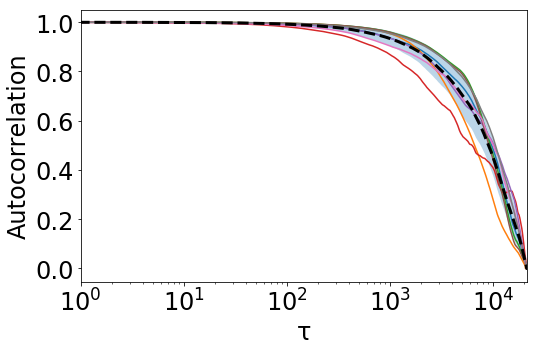

In [345]:
plt.xscale('log')
ax = plt.gca()
_x = np.arange(0, len(t), 1)

Ds = []

skipped = 0
all_acorrs = []

for spot_num in range(N_SPOTS):
    
    
    print("--- Spot %d ---              " % spot_num, end="\r")
    
    autocorrelated = autocorrelate(binned_tot[spot_num])
    
    # Truncate small numbers to 0 to make the zero_array check faster
    autocorrelated[np.abs(autocorrelated) < 1e-2] = 0
    
    all_acorrs.append(autocorrelated)
    
    color = ax._get_lines.get_next_color()
    plt.plot(_x, autocorrelated, color=color, label="Data - Spot %d" % spot_num)

#     if spot_num == 2:
#         color = ax._get_lines.get_next_color()
#         plt.plot(_x, autocorrelated, color='red', linewidth=3, label="Data - Spot %d" % spot_num)
    
# Average together autocorrelations
_acorrs = np.nanmean(all_acorrs, axis=0)
_acorr_std = np.nanstd(all_acorrs, axis=0)

# print(_acorrs)

plt.plot(_x, _acorrs, color='k', linestyle='--', label="Avg Acorr", zorder=4, linewidth=3)

ax = plt.gca()
for item in ([ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() \
             + ax.get_yticklabels() ):
    item.set_fontsize(24)
    
plt.gca().set_facecolor('w')

plt.gcf().set_size_inches(8,5)

try:
    crossing = get_crossing(_x, _acorrs)
    lower_bound = get_crossing(_x, _acorrs-_acorr_std)
    upper_bound = get_crossing(_x, _acorrs+_acorr_std)
except ValueError:
    print("Bad result. Skipping a bin in spot %d" % (spot_num))
    
    print('')

calced_D = w_xy**2 / (4 * crossing)
calced_D_upper = w_xy**2 / (4 * upper_bound)
calced_D_lower = w_xy**2 / (4 * lower_bound)

print("Calculated D=%.3e. (%.3e <-> %.3e)" % (calced_D, calced_D_upper, calced_D_lower))


# _y1 = autocorr_model(_x, calced_D_upper)
# _y2 = autocorr_model(_x, calced_D_lower)
# plt.fill_between(_x, _y1, _y2, alpha=0.5, zorder=3)
plt.fill_between(_x, _acorrs-_acorr_std, _acorrs+_acorr_std, alpha=0.3, zorder=1)
# print(_acorrs-_acorr_std)

print("\nSkipped %d out of %d" % (skipped, N_SPOTS))

# plt.plot(_x, autocorr_model(_x, D), color='k', linestyle='--', linewidth=2, label="Model - Expected")
    

calc_tauD = w_xy**2 / (4 * calced_D)
print("Calculated tauD at %.2f" % calc_tauD)
# print("\n\nAvg. D is %.3f +- %.4f, yielding a tau_D of %.2f compared to the expected %.2f for D=%d" % (np.mean(Ds), np.std(Ds), calc_tauD, tauD, D))

# plt.axvline(calc_tauD)
# plt.axvline(tauD)
# plt.xticks(list(plt.xticks()[0]) + [calc_tauD, tauD], list(plt.xticks()[0]) + ['calculated tau_D', 'expected tau_D'])
# plt.legend()

plt.xlabel('τ')
plt.ylabel('Autocorrelation')

plt.xlim([0,len(t)])

# plt.savefig("acorr-sample.pdf", bbox_inches = "tight", pad_inches = 0.1 )

### Autocorrelate in bins, and then curve fit

#### Group trajectory autocorrelations into bins, then average each bin's data separately
calced_Ds[BIN, SPOT] is filled with the 0.5 crossings for each trajectory. These are then averaged bin-wise

#### Average binned autocorrelations
Autocorrelations are first averaged bin-wise, then the averages are curve-fit

#### Curve-fit each bin's data

# Plot Heatmap

The goal of this is to plot the spots overlaid on the trajectories of the sampled particles, with a heatmap indicating the Gaussian profile that's being used to sample.

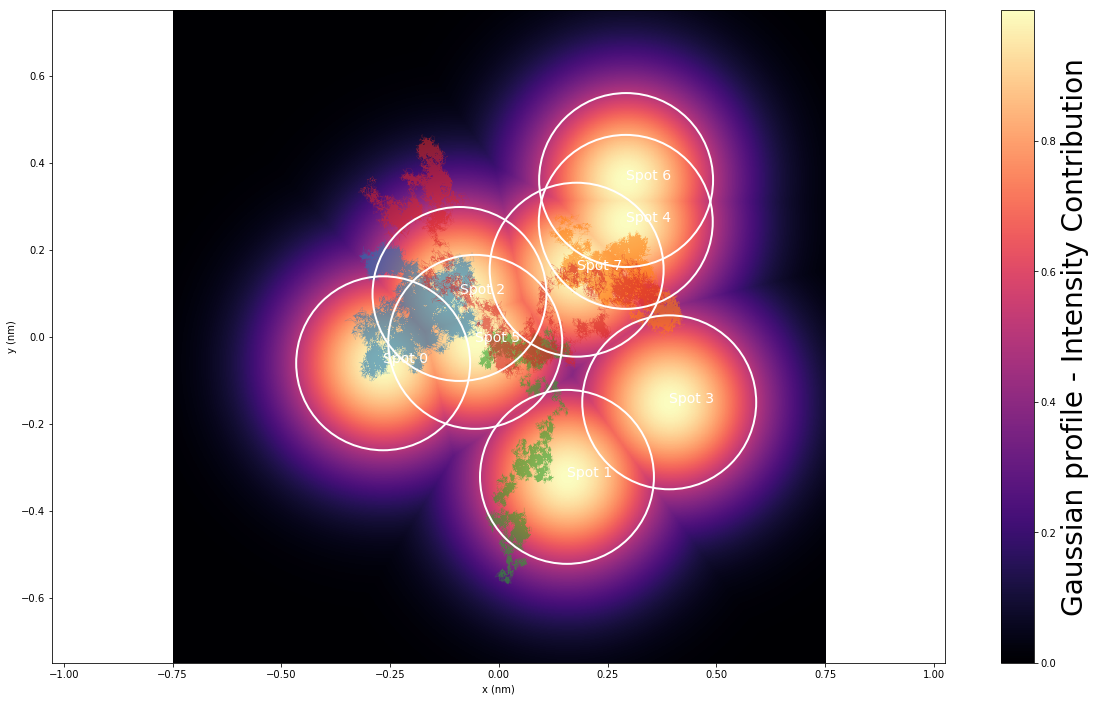

In [346]:
# Make the aspect ratio of the plot square so that the spot circles are circles and not ellipses
plt.axis('equal') 


# spot_centers = np.array([ [np.random.uniform(700,1200), np.random.uniform(1700,2300)] for x in range(1000)])
# spot_centers = np.array([[700,1700],[1020,1800],[940,2000],[1100,2200],[830,2100]])

try:
    spot_centers
except NameError:    
    print("Error - no centers found")
    spot_centers = [[0,0]]
############## Plot trajectories ############## 
for w in range(0, t.topology.n_residues, 1):
    plt.plot(t.xyz[:,w,0], t.xyz[:,w,1], linestyle='-', linewidth=.2, zorder=1, alpha=.6)


############## Plot spots ############## 
ax = plt.gca()
for spot in spot_centers[:N_SPOTS]:
# for spot in [spot_centers[6]]:
    circle = plt.Circle(spot, FWHM/2, fill=False, linewidth=2, ec='white', zorder=3)
    ax.add_artist(circle)
    
    
############## Plot heatmap ############## 
# Get axis ranges to use for heatmap point grid
# xrange = [-1,1]#ax.get_xlim()
# yrange = [-1,1]#ax.get_ylim()
# xrange = [1200, 2665]
# yrange = [1900,2984]
xrange = [-SPOT_RANGE,SPOT_RANGE]#ax.get_xlim()
yrange = [-SPOT_RANGE,SPOT_RANGE]#ax.get_ylim()
plt.xlim(xrange)

# Set the number of points. Make this imaginary so that np.mgrid includes the endpoints.
npoints = 1500j
zpreds = []

# Make a grid of points that will be used to display the Gaussians. May also be able to do this as a countour..
yi, xi = np.mgrid[yrange[1]:yrange[0]:npoints, xrange[0]:xrange[1]:npoints]
xyi = np.vstack([xi.ravel(), yi.ravel()])

# Determine Gaussian profiles for each spot
i=0
# for spot in spot_centers[6]]:
for spot in spot_centers[:N_SPOTS]:
    zpred = gauss2d(xyi, spot, w_xy, cutoff=CUTOFF)
    zpred.shape = xi.shape # Convert Z values from a flat list to a 2-D (x,y) array
    zpreds.append(zpred)
#     plt.annotate(xy=spot, s="Spot", color='w') # The `where` is some magic to get the index of the spot
# # If using multiple spots, uncomment this and comment the line above
    plt.annotate(xy=spot, s="Spot %d" % i, color='w', fontsize=14) # The `where` is some magic to get the index of the spot
    i += 1
    
# Set each Z value to the max at that position, most meaningful way of plotting multiple profiles (?)
zpreds = np.maximum.reduce(zpreds)

# Display Gaussian profiles
im = ax.imshow(zpreds, extent=[xi.min(), xi.max(), yi.min(), yi.max()], aspect='equal', zorder=0, alpha=1, cmap='magma')
cbar = plt.colorbar(im)
cbar.set_label("Gaussian profile - Intensity Contribution",size=28)



plt.xlabel("x (nm)")
plt.ylabel("y (nm)")

# plt.show()

# plt.savefig('gauss.png')

from matplotlib import rc
from matplotlib import rcParams
rcParams.update({'font.size': 28})
from matplotlib.backends.backend_pdf import PdfPages

# image = PdfPages('/home/jrusso/gauss_Ld.pdf')
# image.savefig()
# image.close()

# Bibliography

[1] Chiantia, Salvatore, Jonas Ries, and Petra Schwille. "Fluorescence correlation spectroscopy in membrane structure elucidation." Biochimica et Biophysica Acta (BBA)-Biomembranes 1788.1 (2009): 225-233.

[2] Zgorski, Andrew, and Edward Lyman. "Toward Hydrodynamics with Solvent Free Lipid Models: STRD Martini." Biophysical journal 111.12 (2016): 2689-2697.